# Import of Python libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10,10)
pd.set_option('display.max_columns', 50)

# Import data

In [2]:
data = pd.read_csv("../1. Task and Data/test.csv", sep="|")

# Initial data exploration

In [3]:
data.shape

(498121, 9)

In [4]:
data['trustLevel'] = data['trustLevel'].astype('category')
data.dtypes

trustLevel                   category
totalScanTimeInSeconds          int64
grandTotal                    float64
lineItemVoids                   int64
scansWithoutRegistration        int64
quantityModifications           int64
scannedLineItemsPerSecond     float64
valuePerSecond                float64
lineItemVoidsPerPosition      float64
dtype: object

Almost only numeric data -> Discretization might be necessary for some models

Only 104 frauds out of 1879 instances -> Unbalanced target distribution that needs to be considered during training (e.g., use stratification)

In [5]:
data.isnull().values.any()

False

There are no NULL values in the data
-> no imputation is needed

# Feature Engineering - What information is "hidden" in the data

In [6]:
data['totalScanTimeInMinutes'] = data['totalScanTimeInSeconds'] / 60.0
data['scannedLineItems'] = data['scannedLineItemsPerSecond'] * data['totalScanTimeInSeconds']
data['pricePerScannedLineItem'] = data['grandTotal'] / data['scannedLineItems']
data['scansWithoutRegistrationPerScannedLineItem'] = data['scansWithoutRegistration'] / data['scannedLineItems']
data['quantityModificationsPerScannedLineItem'] = data['quantityModifications'] / data['scannedLineItems']
data['lineItemVoidsPerSecond'] = data['lineItemVoids'] / data['totalScanTimeInSeconds']
data['scansWithoutRegistrationPerSecond'] = data['scansWithoutRegistration'] / data['totalScanTimeInSeconds']
data['quantityModificationsPerSecond'] = data['quantityModifications'] / data['totalScanTimeInSeconds']
data['secondsPerEuro'] = data['totalScanTimeInSeconds'] / data['grandTotal']
data['lineItemVoidsPerEuro'] = data['lineItemVoids'] / data['grandTotal']
data['scansWithoutRegistrationPerEuro'] = data['scansWithoutRegistration'] / data['grandTotal']
data['quantityModificationsPerEuro'] = data['quantityModifications'] / data['grandTotal']

important notes:
- totalScanTimeInMinutes is just another represetation of the original attribute totalScanTimeInSeconds
- secondsPerEuro is just the inverse of the original feature valuePerSecond, but it might have a more natural interpretation
- the original feature lineItemVoidsPerPosition means lineItemVoidsPerScannedLineItem

result of the analysis of the test data set:
- you have to be very careful with the perEuro attributes because in the test data that we have to predict there are some instances with a grandTotal of 0.00 which would result in a division by zero error when trying to compute this feature 

# Overview over all columns

In [29]:
data.describe()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,totalScanTimeInMinutes,scannedLineItems,pricePerScannedLineItem,scansWithoutRegistrationPerScannedLineItem,quantityModificationsPerScannedLineItem,lineItemVoidsPerSecond,scansWithoutRegistrationPerSecond,quantityModificationsPerSecond,secondsPerEuro,lineItemVoidsPerEuro,scansWithoutRegistrationPerEuro,quantityModificationsPerEuro
count,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,498121.000000,4.981210e+05,4.981080e+05,4.981150e+05,4.981070e+05
mean,3.503257,915.608772,49.988990,5.495926,5.001281,2.499015,0.068054,0.222182,0.735190,15.260146,15.486673,6.693747,0.669799,0.336203,0.024370,0.021893,0.010991,inf,inf,inf,inf
std,1.707662,528.772880,28.873426,3.447683,3.163795,1.708182,0.521092,1.717867,1.320235,8.812881,8.667297,11.680538,1.208735,0.627875,0.193313,0.171088,0.088685,NaN,NaN,NaN,NaN
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000546,0.000000,0.000000,0.016667,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.002908e-02,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000,458.000000,24.930000,3.000000,2.000000,1.000000,0.008682,0.027348,0.160000,7.633333,8.000000,1.611200,0.142857,0.062500,0.002735,0.002431,0.001082,9.166667e+00,5.006258e-02,4.447409e-02,1.990446e-02
50%,4.000000,916.000000,50.030000,5.000000,5.000000,2.000000,0.016940,0.054550,0.352941,15.266667,15.000000,3.224706,0.333333,0.160000,0.006002,0.005474,0.002729,1.833183e+01,1.099959e-01,1.002339e-01,5.002501e-02
75%,5.000000,1374.000000,75.020000,8.000000,8.000000,4.000000,0.033929,0.109091,0.692308,22.900000,23.000000,6.272500,0.636364,0.333333,0.012000,0.010959,0.005464,3.656578e+01,2.198608e-01,2.002002e-01,9.996002e-02
max,6.000000,1831.000000,99.990000,11.000000,10.000000,5.000000,30.000000,99.710000,11.000000,30.516667,30.000000,99.990000,10.000000,5.000000,11.000000,10.000000,5.000000,inf,inf,inf,inf


No significant difference compared to train set

# Relationships and Correlation between attributes

In [21]:
data.corr()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,totalScanTimeInMinutes,...,pricePerScannedLineItem,scansWithoutRegistrationPerScannedLineItem,quantityModificationsPerScannedLineItem,lineItemVoidsPerSecond,scansWithoutRegistrationPerSecond,quantityModificationsPerSecond,secondsPerEuro,lineItemVoidsPerEuro,scansWithoutRegistrationPerEuro,quantityModificationsPerEuro
trustLevel,1.000000,0.000065,-0.000718,-0.000436,0.000518,-0.000806,-0.000567,0.000391,0.000469,0.000065,...,0.000416,0.000558,-0.000278,0.000609,0.000541,-0.000329,0.001270,0.000967,0.000652,-0.000249
totalScanTimeInSeconds,0.000065,1.000000,-0.001570,-0.000619,-0.000886,-0.000602,-0.169937,-0.168923,-0.000038,1.000000,...,0.000395,-0.000054,-0.000424,-0.164523,-0.166298,-0.161308,0.038173,-0.000119,-0.000885,0.001225
grandTotal,-0.000718,-0.001570,1.000000,0.000872,0.001876,0.000314,0.000578,0.075609,-0.000773,-0.001570,...,0.330849,0.000644,-0.000863,0.000375,-0.000908,-0.000155,-0.093122,-0.089021,-0.089489,-0.094172
lineItemVoids,-0.000436,-0.000619,0.000872,1.000000,0.001962,-0.000974,-0.001085,-0.000131,0.348968,-0.000619,...,-0.001650,-0.000773,-0.002321,0.079605,0.000090,-0.000297,0.001460,0.039344,0.000655,0.002403
scansWithoutRegistration,0.000518,-0.000886,0.001876,0.001962,1.000000,0.000079,-0.002141,-0.003911,0.000252,-0.000886,...,0.000750,0.350696,-0.000086,-0.002458,0.079162,-0.002754,-0.001493,-0.001455,0.039102,-0.001418
quantityModifications,-0.000806,-0.000602,0.000314,-0.000974,0.000079,1.000000,-0.003039,-0.002115,0.002425,-0.000602,...,0.003158,0.003601,0.368195,-0.001774,-0.001764,0.083908,0.000767,0.000445,-0.000908,0.045388
scannedLineItemsPerSecond,-0.000567,-0.169937,0.000578,-0.001085,-0.002141,-0.003039,1.000000,0.746334,-0.037303,-0.169937,...,-0.038339,-0.037610,-0.036338,0.712715,0.732334,0.690827,-0.006574,0.004730,0.002767,0.000312
valuePerSecond,0.000391,-0.168923,0.075609,-0.000131,-0.003911,-0.002115,0.746334,1.000000,0.002359,-0.168923,...,0.026056,-0.000235,0.001397,0.723868,0.692700,0.699829,-0.008272,-0.006653,-0.006709,-0.007052
lineItemVoidsPerPosition,0.000469,-0.000038,-0.000773,0.348968,0.000252,0.002425,-0.037303,0.002359,1.000000,-0.000038,...,0.645366,0.627084,0.609747,0.031756,0.001115,0.003914,-0.000131,0.012764,-0.000398,0.001395
totalScanTimeInMinutes,0.000065,1.000000,-0.001570,-0.000619,-0.000886,-0.000602,-0.169937,-0.168923,-0.000038,1.000000,...,0.000395,-0.000054,-0.000424,-0.164523,-0.166298,-0.161308,0.038173,-0.000119,-0.000885,0.001225


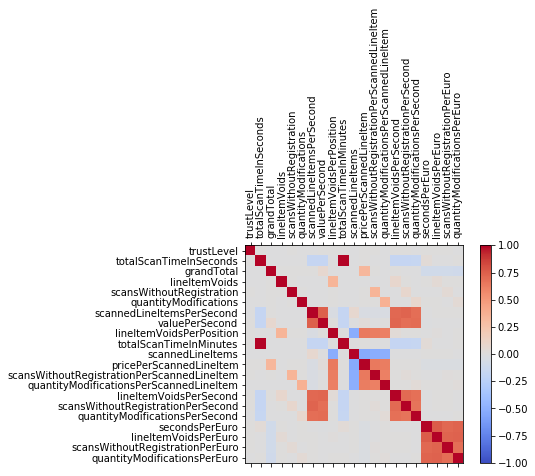

In [22]:
corr = data.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(data.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(data.columns)
ax.set_yticklabels(data.columns)
plt.show()

# Check for outliers - Check the 30 largest and smallest values

In [23]:
df = pd.DataFrame(pd.concat([data['trustLevel'].sort_values(ascending = False)[:30].reset_index(drop=True), data['trustLevel'].sort_values(ascending = True)[:30].reset_index(drop=True)], axis=1))
df.columns = ["trustLevel - Largest Values", "trustLevel - Smallest Values"]
df

,trustLevel - Largest Values,trustLevel - Smallest Values
0,6,1
1,6,1
2,6,1
3,6,1
4,6,1
5,6,1
6,6,1
7,6,1
8,6,1
9,6,1


In [24]:
df = pd.DataFrame(pd.concat([data['totalScanTimeInSeconds'].sort_values(ascending = False)[:30].reset_index(drop=True), data['totalScanTimeInSeconds'].sort_values(ascending = True)[:30].reset_index(drop=True)], axis=1))
df.columns = ["totalScanTimeInSeconds - Largest Values", "totalScanTimeInSeconds - Smallest Values"]
df

,totalScanTimeInSeconds - Largest Values,totalScanTimeInSeconds - Smallest Values
0,1831,1
1,1831,1
2,1831,1
3,1831,1
4,1831,1
5,1831,1
6,1831,1
7,1831,1
8,1831,1
9,1831,1


Like in the train set, there are also very short scan times

In [32]:
df = pd.DataFrame(pd.concat([data['grandTotal'].sort_values(ascending = False)[:30].reset_index(drop=True), data['grandTotal'].sort_values(ascending = True)[:30].reset_index(drop=True)], axis=1))
df.columns = ["grandTotal - Largest Values", "grandTotal - Smallest Values"]
df

,grandTotal - Largest Values,grandTotal - Smallest Values
0,99.99,0.0
1,99.99,0.0
2,99.99,0.0
3,99.99,0.0
4,99.99,0.0
5,99.99,0.0
6,99.99,0.0
7,99.99,0.0
8,99.99,0.0
9,99.99,0.0


There are even instances with 0 grandTotal -> this needs to be considered when we want to include a perEuro attribute into our model

In [30]:
data[data['grandTotal'] == 0.0]

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,totalScanTimeInMinutes,scannedLineItems,pricePerScannedLineItem,scansWithoutRegistrationPerScannedLineItem,quantityModificationsPerScannedLineItem,lineItemVoidsPerSecond,scansWithoutRegistrationPerSecond,quantityModificationsPerSecond,secondsPerEuro,lineItemVoidsPerEuro,scansWithoutRegistrationPerEuro,quantityModificationsPerEuro
13695,4,724,0.0,0,2,4,0.041436,0.0,0.000000,12.066667,30.0,0.0,0.066667,0.133333,0.000000,0.002762,0.005525,inf,NaN,inf,inf
19792,3,1228,0.0,11,5,4,0.006515,0.0,1.375000,20.466667,8.0,0.0,0.625000,0.500000,0.008958,0.004072,0.003257,inf,inf,inf,inf
29990,4,1744,0.0,9,5,1,0.010321,0.0,0.500000,29.066667,18.0,0.0,0.277778,0.055556,0.005161,0.002867,0.000573,inf,inf,inf,inf
30187,6,75,0.0,8,0,1,0.346667,0.0,0.307692,1.250000,26.0,0.0,0.000000,0.038462,0.106667,0.000000,0.013333,inf,inf,NaN,inf
30423,6,767,0.0,9,5,1,0.006519,0.0,1.800000,12.783333,5.0,0.0,1.000000,0.200000,0.011734,0.006519,0.001304,inf,inf,inf,inf
34895,3,1536,0.0,8,8,4,0.013672,0.0,0.380952,25.600000,21.0,0.0,0.380952,0.190476,0.005208,0.005208,0.002604,inf,inf,inf,inf
35561,4,1020,0.0,9,10,2,0.011765,0.0,0.750000,17.000000,12.0,0.0,0.833333,0.166667,0.008824,0.009804,0.001961,inf,inf,inf,inf
40562,5,1675,0.0,8,0,1,0.007164,0.0,0.666667,27.916667,12.0,0.0,0.000000,0.083333,0.004776,0.000000,0.000597,inf,inf,NaN,inf
43649,5,914,0.0,11,2,4,0.022976,0.0,0.523810,15.233333,21.0,0.0,0.095238,0.190476,0.012035,0.002188,0.004376,inf,inf,inf,inf
46561,3,1506,0.0,4,5,5,0.001328,0.0,2.000000,25.100000,2.0,0.0,2.500000,2.500000,0.002656,0.003320,0.003320,inf,inf,inf,inf


Very difficult to make sense out of this instances, maybe some sort of discount is used that reduces the grandTotal although a number of items have been scanned

In [33]:
df = pd.DataFrame(pd.concat([data['scannedLineItems'].sort_values(ascending = False)[:30].reset_index(drop=True), data['scannedLineItems'].sort_values(ascending = True)[:30].reset_index(drop=True)], axis=1))
df.columns = ["scannedLineItems - Largest Values", "scannedLineItems - Smallest Values"]
df

,scannedLineItems - Largest Values,scannedLineItems - Smallest Values
0,30.0,1.0
1,30.0,1.0
2,30.0,1.0
3,30.0,1.0
4,30.0,1.0
5,30.0,1.0
6,30.0,1.0
7,30.0,1.0
8,30.0,1.0
9,30.0,1.0


not more than 30 items purchased, like in the train set

In [34]:
df = pd.DataFrame(pd.concat([data['lineItemVoids'].sort_values(ascending = False)[:30].reset_index(drop=True), data['lineItemVoids'].sort_values(ascending = True)[:30].reset_index(drop=True)], axis=1))
df.columns = ["lineItemVoids - Largest Values", "lineItemVoids - Smallest Values"]
df

,lineItemVoids - Largest Values,lineItemVoids - Smallest Values
0,11,0
1,11,0
2,11,0
3,11,0
4,11,0
5,11,0
6,11,0
7,11,0
8,11,0
9,11,0


In [35]:
df = pd.DataFrame(pd.concat([data['scansWithoutRegistration'].sort_values(ascending = False)[:30].reset_index(drop=True), data['scansWithoutRegistration'].sort_values(ascending = True)[:30].reset_index(drop=True)], axis=1))
df.columns = ["scansWithoutRegistration - Largest Values", "scansWithoutRegistration - Smallest Values"]
df

,scansWithoutRegistration - Largest Values,scansWithoutRegistration - Smallest Values
0,10,0
1,10,0
2,10,0
3,10,0
4,10,0
5,10,0
6,10,0
7,10,0
8,10,0
9,10,0


In [36]:
df = pd.DataFrame(pd.concat([data['quantityModifications'].sort_values(ascending = False)[:30].reset_index(drop=True), data['quantityModifications'].sort_values(ascending = True)[:30].reset_index(drop=True)], axis=1))
df.columns = ["quantityModifications - Largest Values", "quantityModifications - Smallest Values"]
df

,quantityModifications - Largest Values,quantityModifications - Smallest Values
0,5,0
1,5,0
2,5,0
3,5,0
4,5,0
5,5,0
6,5,0
7,5,0
8,5,0
9,5,0


In [37]:
df = pd.DataFrame(pd.concat([data['scannedLineItemsPerSecond'].sort_values(ascending = False)[:30].reset_index(drop=True), data['scannedLineItemsPerSecond'].sort_values(ascending = True)[:30].reset_index(drop=True)], axis=1))
df.columns = ["scannedLineItemsPerSecond - Largest Values", "scannedLineItemsPerSecond - Smallest Values"]
df

,scannedLineItemsPerSecond - Largest Values,scannedLineItemsPerSecond - Smallest Values
0,30.0,0.000546
1,30.0,0.000546
2,30.0,0.000546
3,30.0,0.000546
4,30.0,0.000546
5,30.0,0.000546
6,30.0,0.000546
7,30.0,0.000546
8,30.0,0.000546
9,30.0,0.000547


Even more extreme values than in the train set

In [38]:
df = pd.DataFrame(pd.concat([data['valuePerSecond'].sort_values(ascending = False)[:30].reset_index(drop=True), data['valuePerSecond'].sort_values(ascending = True)[:30].reset_index(drop=True)], axis=1))
df.columns = ["valuePerSecond - Largest Values", "valuePerSecond - Smallest Values"]
df

,valuePerSecond - Largest Values,valuePerSecond - Smallest Values
0,99.71,0.0
1,99.56,0.0
2,99.40,0.0
3,98.91,0.0
4,98.46,0.0
5,98.26,0.0
6,96.53,0.0
7,96.38,0.0
8,96.24,0.0
9,95.70,0.0


In [39]:
df = pd.DataFrame(pd.concat([data['lineItemVoidsPerPosition'].sort_values(ascending = False)[:30].reset_index(drop=True), data['lineItemVoidsPerPosition'].sort_values(ascending = True)[:30].reset_index(drop=True)], axis=1))
df.columns = ["lineItemVoidsPerPosition - Largest Values", "lineItemVoidsPerPosition - Smallest Values"]
df

,lineItemVoidsPerPosition - Largest Values,lineItemVoidsPerPosition - Smallest Values
0,11.0,0.0
1,11.0,0.0
2,11.0,0.0
3,11.0,0.0
4,11.0,0.0
5,11.0,0.0
6,11.0,0.0
7,11.0,0.0
8,11.0,0.0
9,11.0,0.0


# Distribution of attributes

Text(0, 0.5, 'Number of Instances')

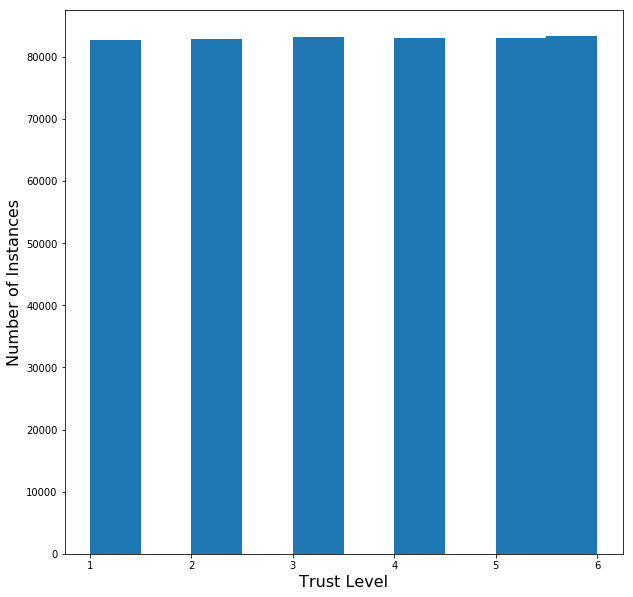

In [44]:
plt.hist(data['trustLevel'])
plt.xlabel('Trust Level',fontsize=16)
plt.ylabel('Number of Instances',fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg')

count    498121.000000
mean          3.503257
std           1.707662
min           1.000000
25%           2.000000
50%           4.000000
75%           5.000000
max           6.000000
Name: trustLevel, dtype: float64

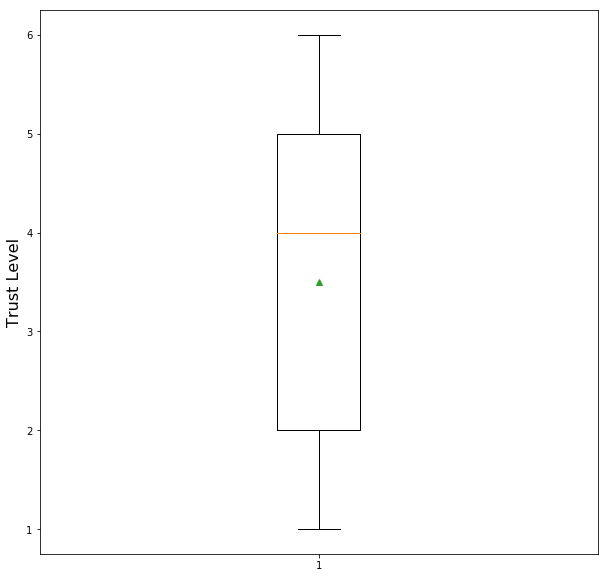

In [47]:
plt.boxplot(data['trustLevel'],  whis='range', showmeans=True)
plt.ylabel('Trust Level' ,fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg
data['trustLevel'].describe()

Text(0, 0.5, 'Number of Instances')

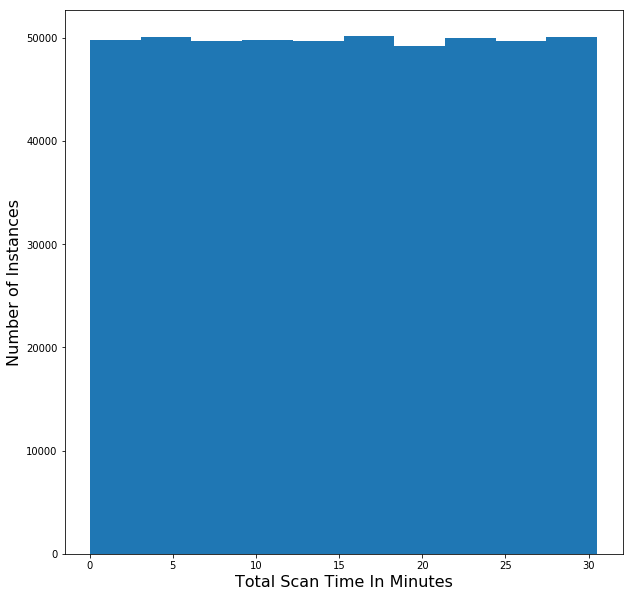

In [48]:
plt.hist(data['totalScanTimeInMinutes'])
plt.xlabel('Total Scan Time In Minutes',fontsize=16)
plt.ylabel('Number of Instances',fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg')

count    498121.000000
mean         15.260146
std           8.812881
min           0.016667
25%           7.633333
50%          15.266667
75%          22.900000
max          30.516667
Name: totalScanTimeInMinutes, dtype: float64

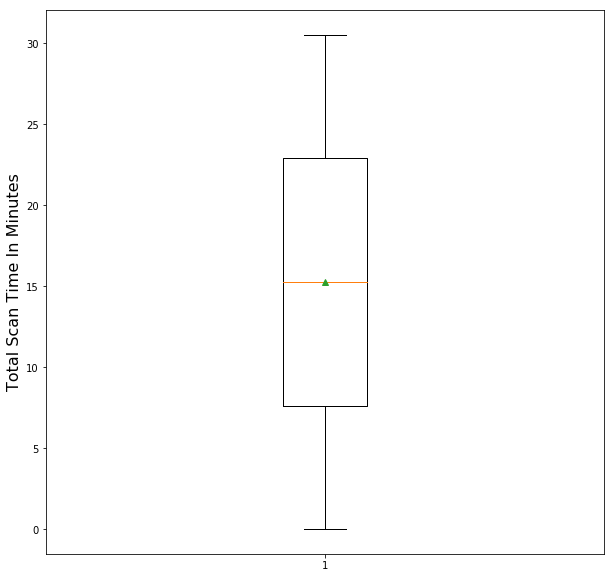

In [49]:
plt.boxplot(data['totalScanTimeInMinutes'],  whis='range', showmeans=True)
plt.ylabel('Total Scan Time In Minutes' ,fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg
data['totalScanTimeInMinutes'].describe()

Text(0, 0.5, 'Number of Instances')

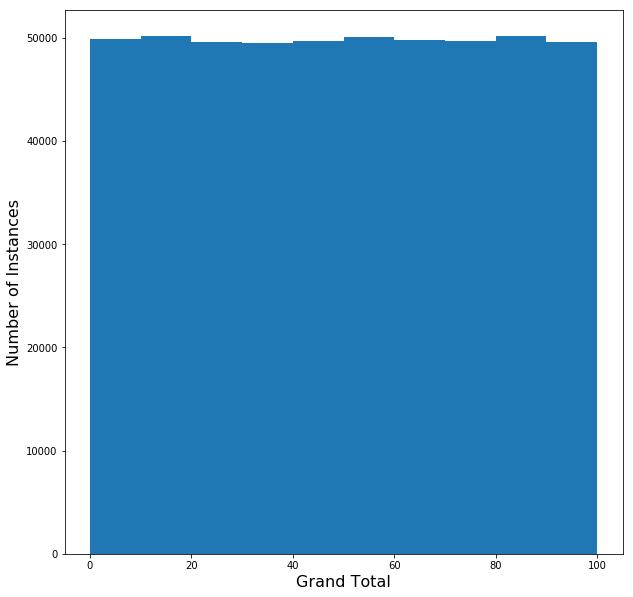

In [50]:
plt.hist(data['grandTotal'])
plt.xlabel('Grand Total',fontsize=16)
plt.ylabel('Number of Instances',fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg')

count    498121.000000
mean         49.988990
std          28.873426
min           0.000000
25%          24.930000
50%          50.030000
75%          75.020000
max          99.990000
Name: grandTotal, dtype: float64

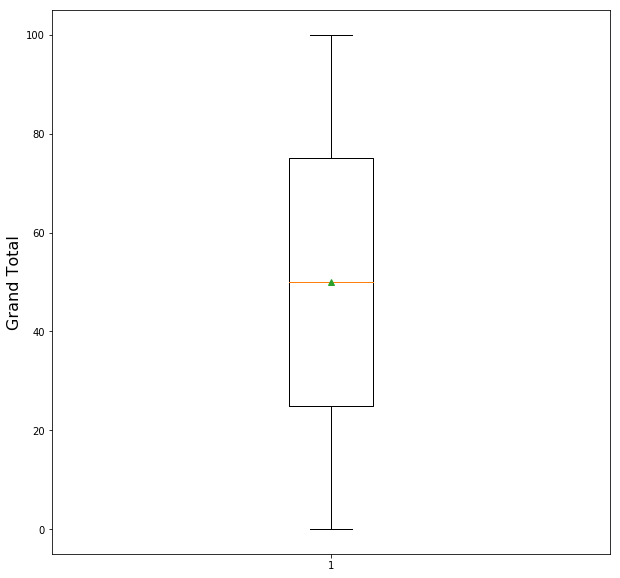

In [51]:
plt.boxplot(data['grandTotal'],  whis='range', showmeans=True)
plt.ylabel('Grand Total' ,fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg
data['grandTotal'].describe()

Text(0, 0.5, 'Number of Instances')

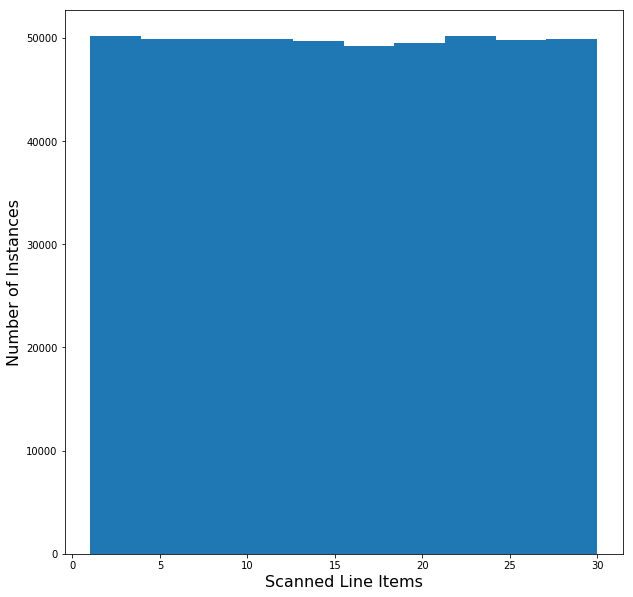

In [52]:
plt.hist(data['scannedLineItems'])
plt.xlabel('Scanned Line Items',fontsize=16)
plt.ylabel('Number of Instances',fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg')

count    498121.000000
mean         15.486673
std           8.667297
min           1.000000
25%           8.000000
50%          15.000000
75%          23.000000
max          30.000000
Name: scannedLineItems, dtype: float64

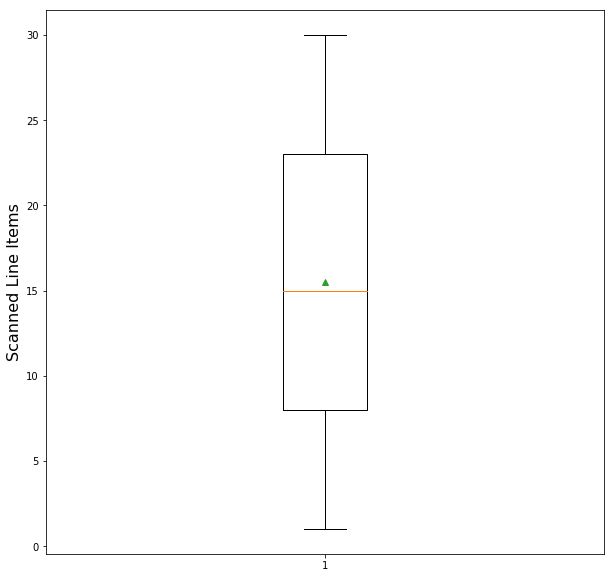

In [53]:
plt.boxplot(data['scannedLineItems'],  whis='range', showmeans=True)
plt.ylabel('Scanned Line Items' ,fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg
data['scannedLineItems'].describe()

Text(0, 0.5, 'Number of Instances')

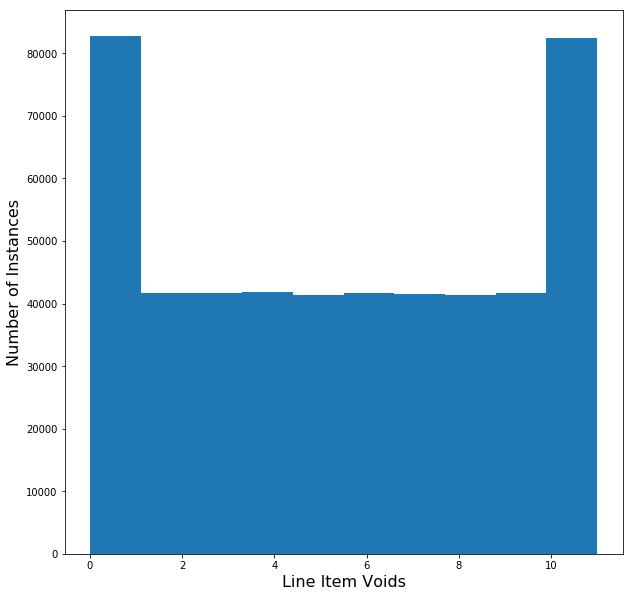

In [54]:
plt.hist(data['lineItemVoids'])
plt.xlabel('Line Item Voids',fontsize=16)
plt.ylabel('Number of Instances',fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg')

interesting concentration of extreme cases

count    498121.000000
mean          5.495926
std           3.447683
min           0.000000
25%           3.000000
50%           5.000000
75%           8.000000
max          11.000000
Name: lineItemVoids, dtype: float64

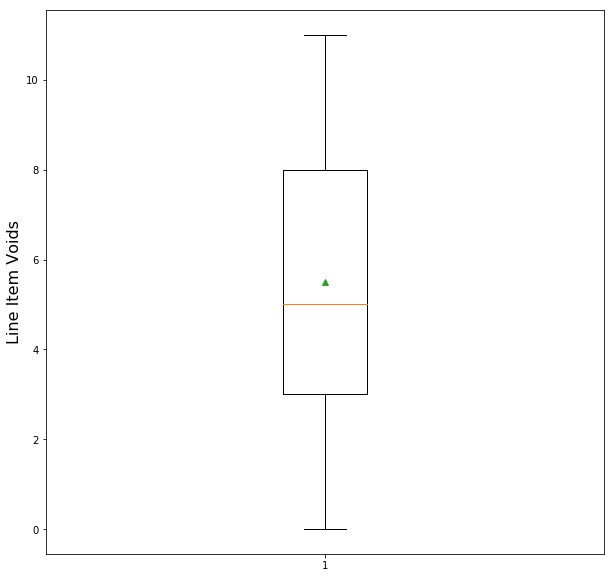

In [55]:
plt.boxplot(data['lineItemVoids'],  whis='range', showmeans=True)
plt.ylabel('Line Item Voids' ,fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg
data['lineItemVoids'].describe()

Text(0, 0.5, 'Number of Instances')

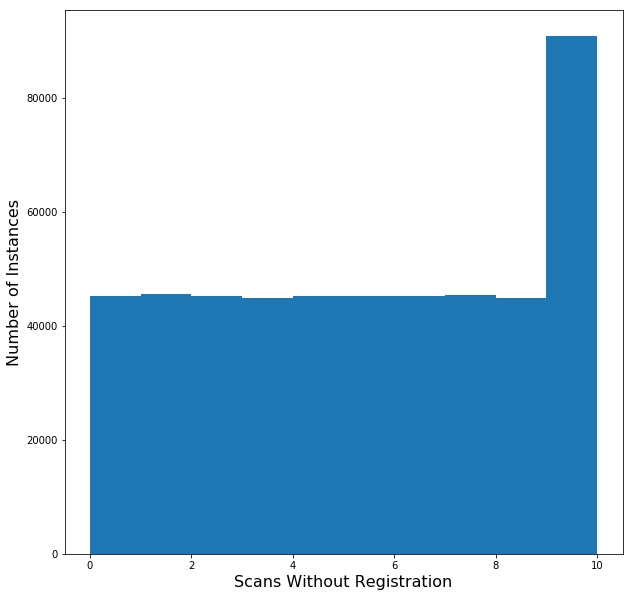

In [56]:
plt.hist(data['scansWithoutRegistration'])
plt.xlabel('Scans Without Registration',fontsize=16)
plt.ylabel('Number of Instances',fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg')

most instances have many scans without registration

count    498121.000000
mean          5.001281
std           3.163795
min           0.000000
25%           2.000000
50%           5.000000
75%           8.000000
max          10.000000
Name: scansWithoutRegistration, dtype: float64

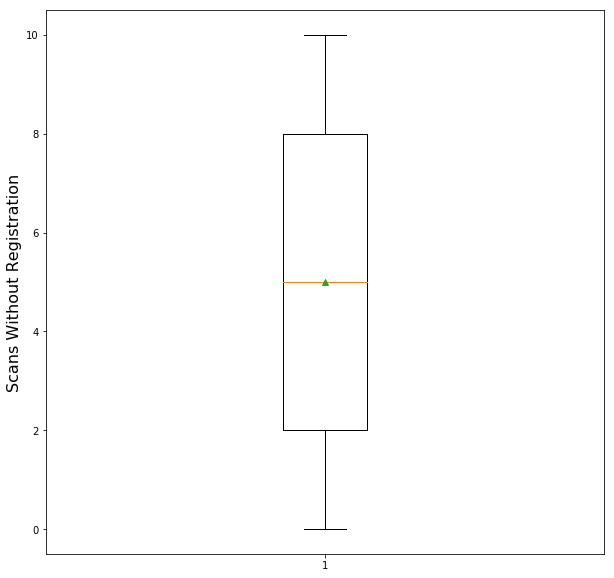

In [57]:
plt.boxplot(data['scansWithoutRegistration'],  whis='range', showmeans=True)
plt.ylabel('Scans Without Registration' ,fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg
data['scansWithoutRegistration'].describe()

Text(0, 0.5, 'Number of Instances')

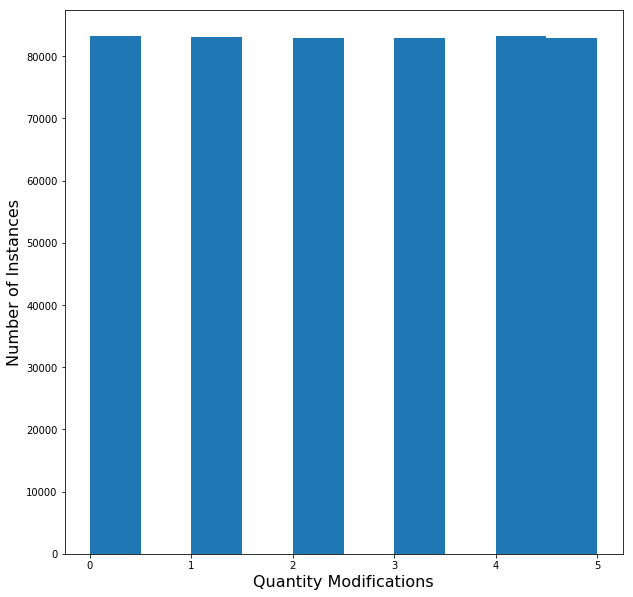

In [58]:
plt.hist(data['quantityModifications'])
plt.xlabel('Quantity Modifications',fontsize=16)
plt.ylabel('Number of Instances',fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg')

count    498121.000000
mean          2.499015
std           1.708182
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max           5.000000
Name: quantityModifications, dtype: float64

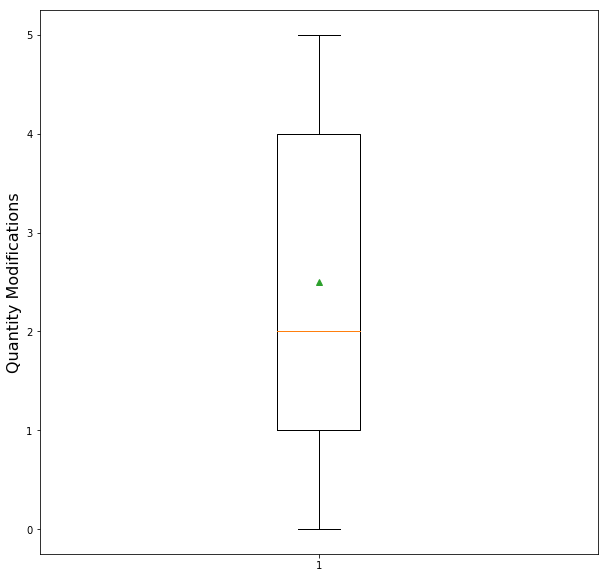

In [59]:
plt.boxplot(data['quantityModifications'],  whis='range', showmeans=True)
plt.ylabel('Quantity Modifications' ,fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg
data['quantityModifications'].describe()

Text(0, 0.5, 'Number of Instances')

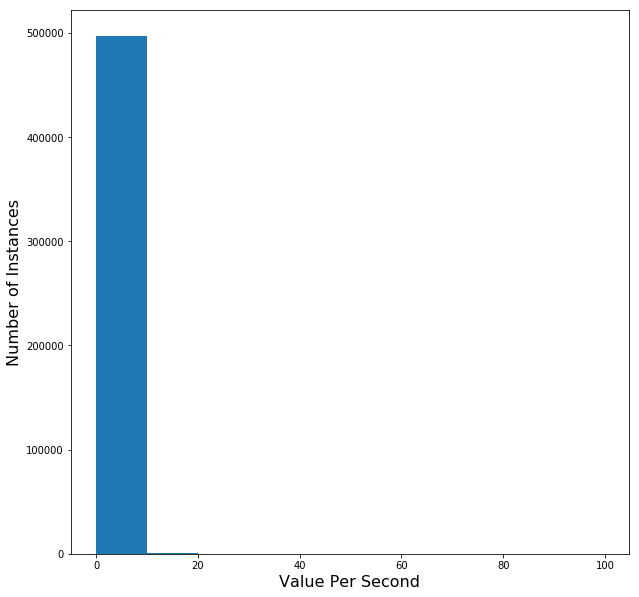

In [60]:
plt.hist(data['valuePerSecond'])
plt.xlabel('Value Per Second',fontsize=16)
plt.ylabel('Number of Instances',fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg')

count    498121.000000
mean          0.222182
std           1.717867
min           0.000000
25%           0.027348
50%           0.054550
75%           0.109091
max          99.710000
Name: valuePerSecond, dtype: float64

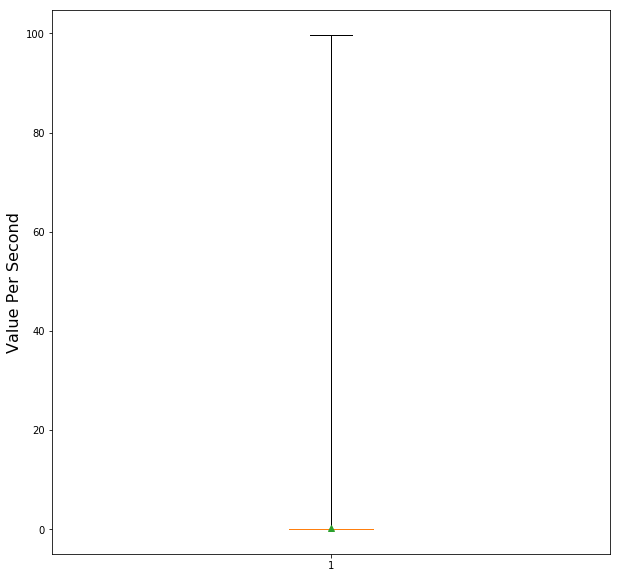

In [61]:
plt.boxplot(data['valuePerSecond'],  whis='range', showmeans=True)
plt.ylabel('Value Per Second' ,fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg
data['valuePerSecond'].describe()

Text(0, 0.5, 'Number of Instances')

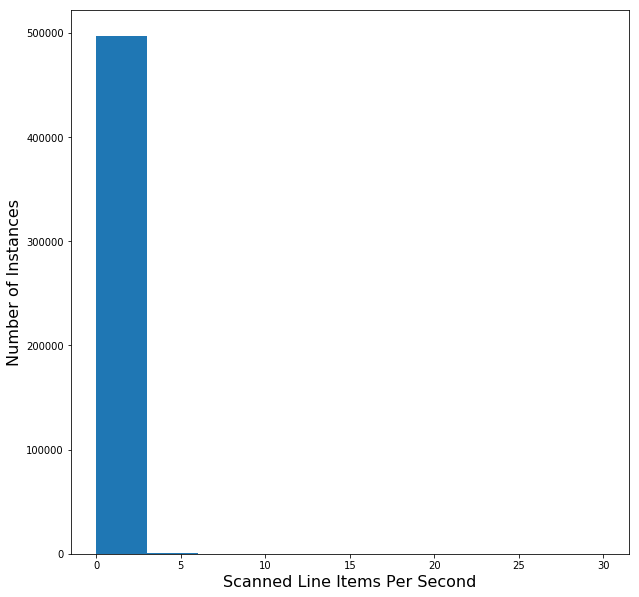

In [64]:
plt.hist(data['scannedLineItemsPerSecond'])
plt.xlabel('Scanned Line Items Per Second',fontsize=16)
plt.ylabel('Number of Instances',fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg')

count    498121.000000
mean          0.068054
std           0.521092
min           0.000546
25%           0.008682
50%           0.016940
75%           0.033929
max          30.000000
Name: scannedLineItemsPerSecond, dtype: float64

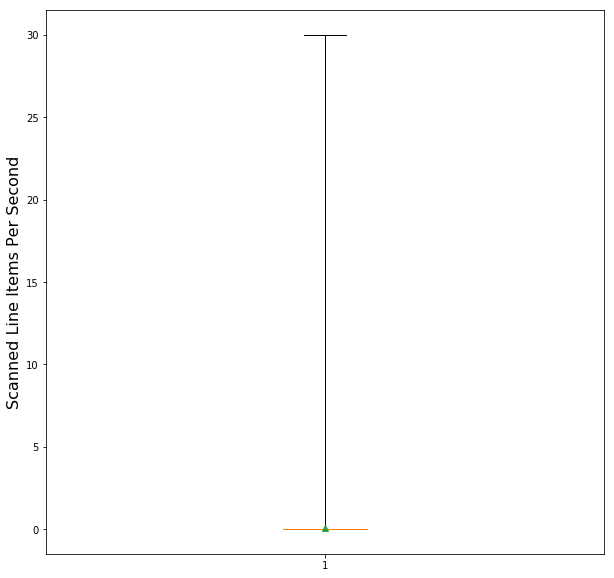

In [65]:
plt.boxplot(data['scannedLineItemsPerSecond'],  whis='range', showmeans=True)
plt.ylabel('Scanned Line Items Per Second' ,fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg
data['scannedLineItemsPerSecond'].describe()

Text(0, 0.5, 'Number of Instances')

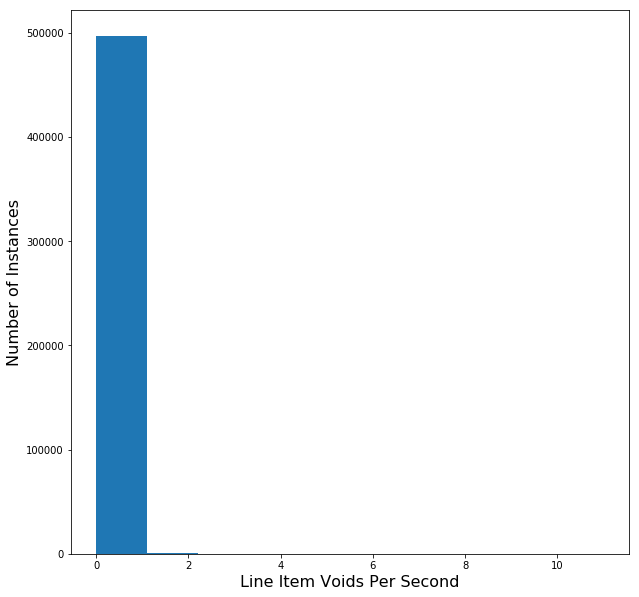

In [66]:
plt.hist(data['lineItemVoidsPerSecond'])
plt.xlabel('Line Item Voids Per Second',fontsize=16)
plt.ylabel('Number of Instances',fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg')

count    498121.000000
mean          0.024370
std           0.193313
min           0.000000
25%           0.002735
50%           0.006002
75%           0.012000
max          11.000000
Name: lineItemVoidsPerSecond, dtype: float64

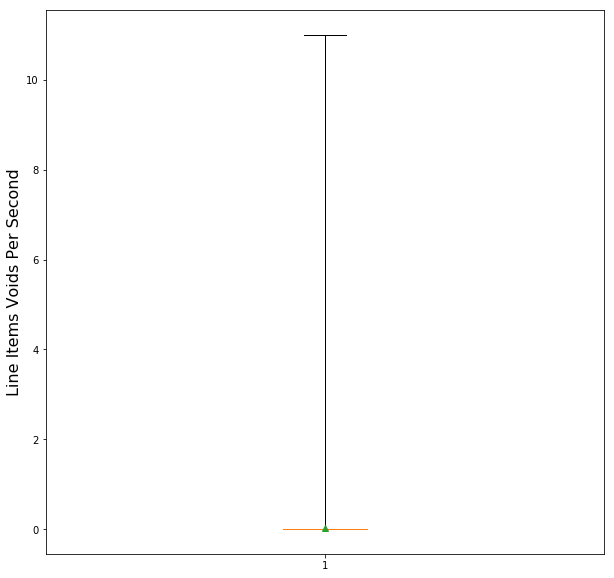

In [67]:
plt.boxplot(data['lineItemVoidsPerSecond'],  whis='range', showmeans=True)
plt.ylabel('Line Items Voids Per Second' ,fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg
data['lineItemVoidsPerSecond'].describe()

Text(0, 0.5, 'Number of Instances')

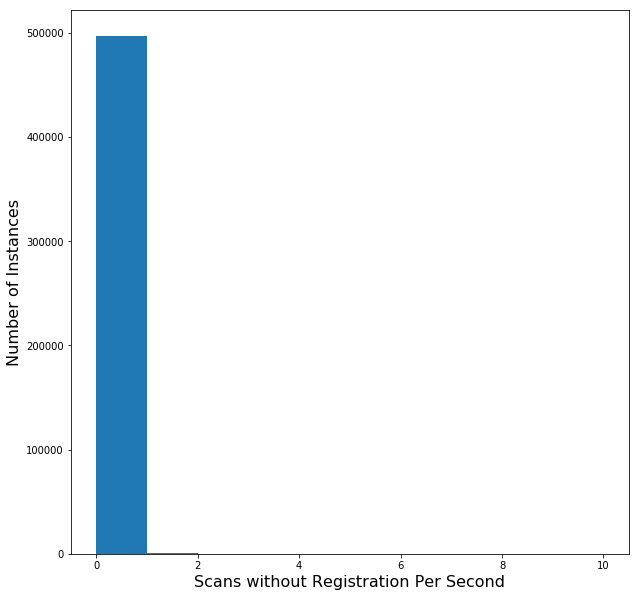

In [68]:
plt.hist(data['scansWithoutRegistrationPerSecond'])
plt.xlabel('Scans without Registration Per Second',fontsize=16)
plt.ylabel('Number of Instances',fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg')

count    498121.000000
mean          0.021893
std           0.171088
min           0.000000
25%           0.002431
50%           0.005474
75%           0.010959
max          10.000000
Name: scansWithoutRegistrationPerSecond, dtype: float64

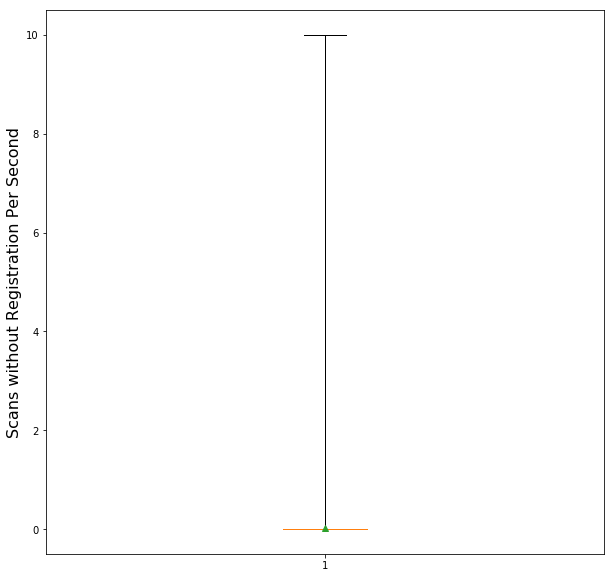

In [69]:
plt.boxplot(data['scansWithoutRegistrationPerSecond'],  whis='range', showmeans=True)
plt.ylabel('Scans without Registration Per Second' ,fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg
data['scansWithoutRegistrationPerSecond'].describe()

Text(0, 0.5, 'Number of Instances')

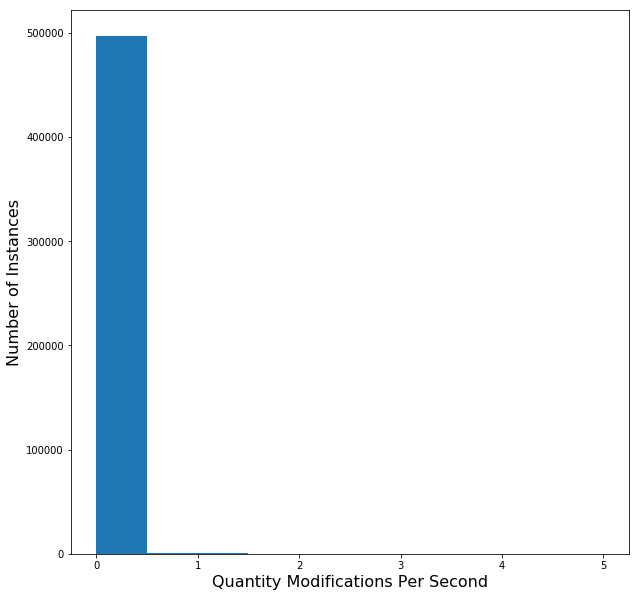

In [70]:
plt.hist(data['quantityModificationsPerSecond'])
plt.xlabel('Quantity Modifications Per Second',fontsize=16)
plt.ylabel('Number of Instances',fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg')

count    498121.000000
mean          0.010991
std           0.088685
min           0.000000
25%           0.001082
50%           0.002729
75%           0.005464
max           5.000000
Name: quantityModificationsPerSecond, dtype: float64

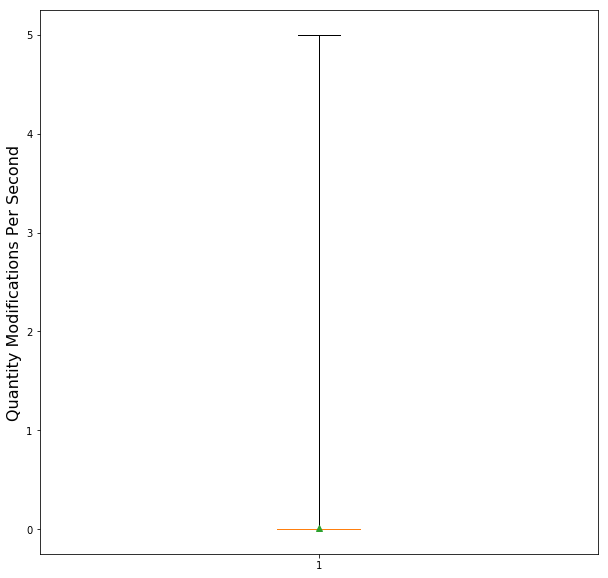

In [71]:
plt.boxplot(data['quantityModificationsPerSecond'],  whis='range', showmeans=True)
plt.ylabel('Quantity Modifications Per Second' ,fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg
data['quantityModificationsPerSecond'].describe()

Text(0, 0.5, 'Number of Instances')

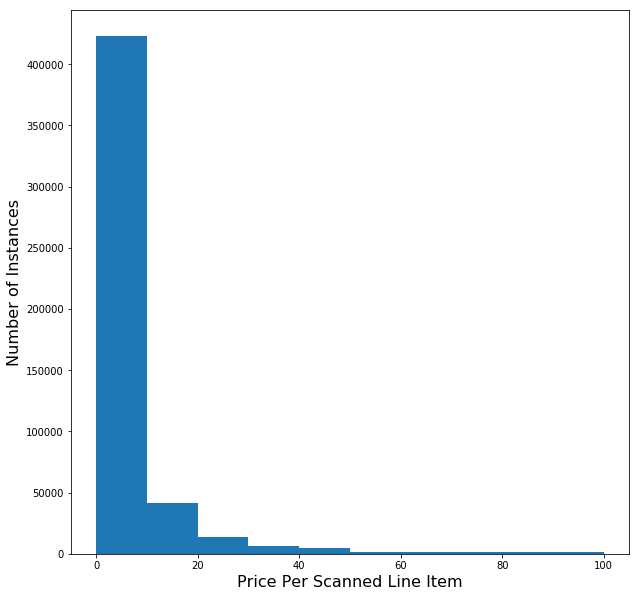

In [72]:
plt.hist(data['pricePerScannedLineItem'])
plt.xlabel('Price Per Scanned Line Item',fontsize=16)
plt.ylabel('Number of Instances',fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg')

count    498121.000000
mean          6.693747
std          11.680538
min           0.000000
25%           1.611200
50%           3.224706
75%           6.272500
max          99.990000
Name: pricePerScannedLineItem, dtype: float64

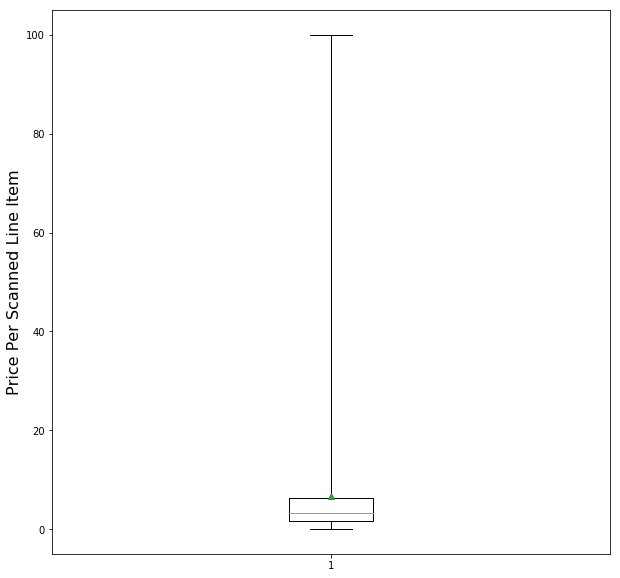

In [73]:
plt.boxplot(data['pricePerScannedLineItem'],  whis='range', showmeans=True)
plt.ylabel('Price Per Scanned Line Item' ,fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg
data['pricePerScannedLineItem'].describe()

Text(0, 0.5, 'Number of Instances')

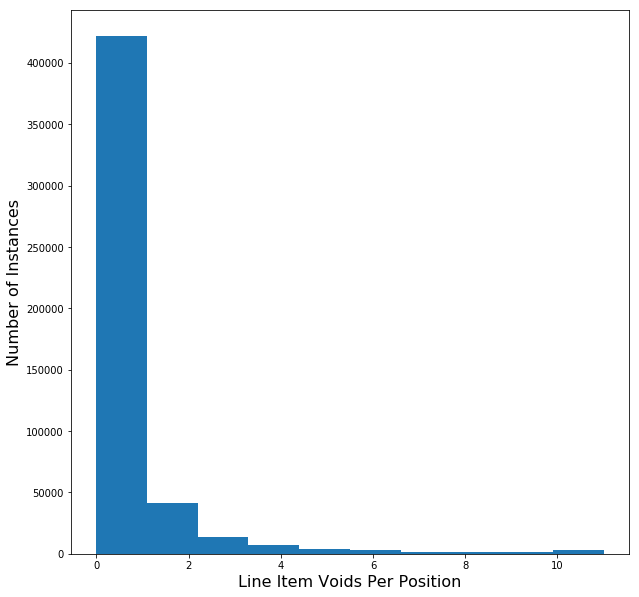

In [74]:
plt.hist(data['lineItemVoidsPerPosition'])
plt.xlabel('Line Item Voids Per Position',fontsize=16)
plt.ylabel('Number of Instances',fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg')

count    498121.000000
mean          0.735190
std           1.320235
min           0.000000
25%           0.160000
50%           0.352941
75%           0.692308
max          11.000000
Name: lineItemVoidsPerPosition, dtype: float64

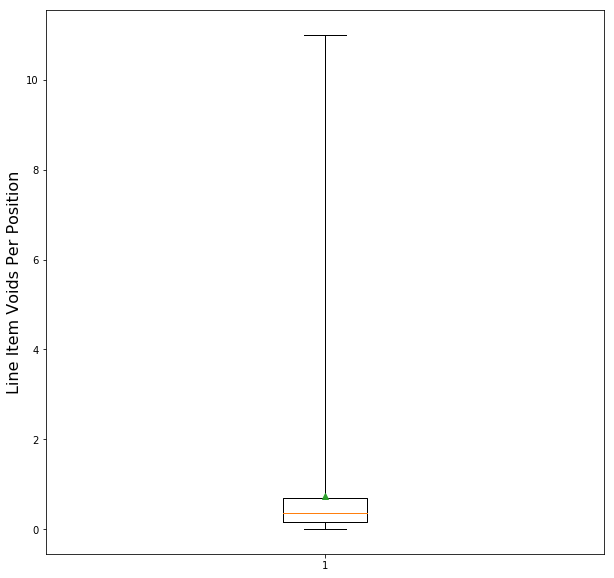

In [75]:
plt.boxplot(data['lineItemVoidsPerPosition'],  whis='range', showmeans=True)
plt.ylabel('Line Item Voids Per Position' ,fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg
data['lineItemVoidsPerPosition'].describe()

Text(0, 0.5, 'Number of Instances')

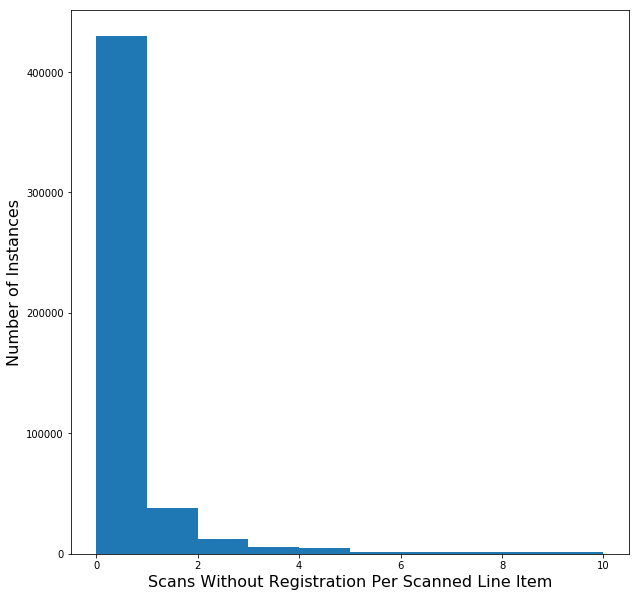

In [76]:
plt.hist(data['scansWithoutRegistrationPerScannedLineItem'])
plt.xlabel('Scans Without Registration Per Scanned Line Item',fontsize=16)
plt.ylabel('Number of Instances',fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg')

count    498121.000000
mean          0.669799
std           1.208735
min           0.000000
25%           0.142857
50%           0.333333
75%           0.636364
max          10.000000
Name: scansWithoutRegistrationPerScannedLineItem, dtype: float64

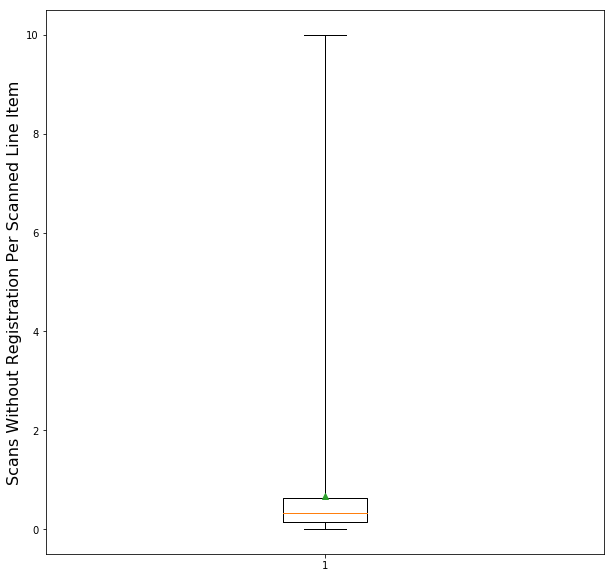

In [77]:
plt.boxplot(data['scansWithoutRegistrationPerScannedLineItem'],  whis='range', showmeans=True)
plt.ylabel('Scans Without Registration Per Scanned Line Item' ,fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg
data['scansWithoutRegistrationPerScannedLineItem'].describe()

Text(0, 0.5, 'Number of Instances')

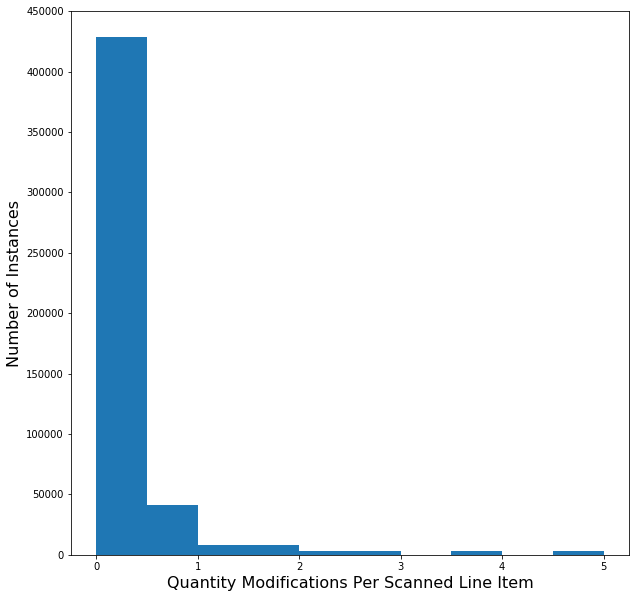

In [78]:
plt.hist(data['quantityModificationsPerScannedLineItem'])
plt.xlabel('Quantity Modifications Per Scanned Line Item',fontsize=16)
plt.ylabel('Number of Instances',fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg')

count    498121.000000
mean          0.336203
std           0.627875
min           0.000000
25%           0.062500
50%           0.160000
75%           0.333333
max           5.000000
Name: quantityModificationsPerScannedLineItem, dtype: float64

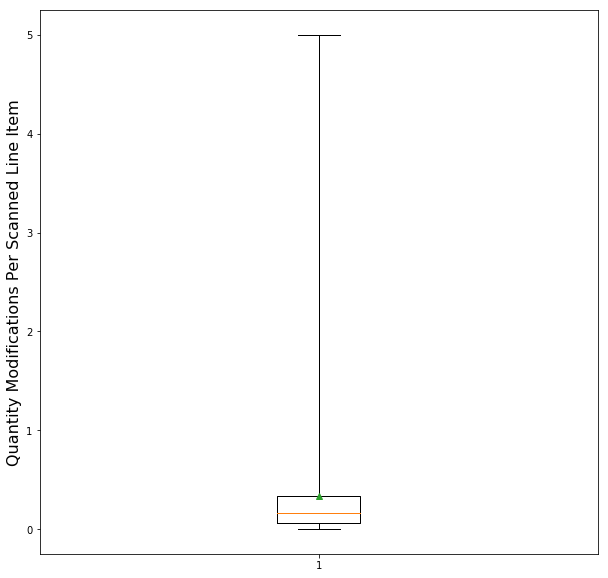

In [79]:
plt.boxplot(data['quantityModificationsPerScannedLineItem'],  whis='range', showmeans=True)
plt.ylabel('Quantity Modifications Per Scanned Line Item' ,fontsize=16)
#plt.savefig('Trust Level Fraud Distribution.jpg
data['quantityModificationsPerScannedLineItem'].describe()